### 전처리


In [ ]:
import bz2
import gdown
import zipfile
import os
import dlib
import cv2
import glob
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


한 폴더에 남자배우1,2,3 /여자배우 1,2,3 zip 파일 합치기

In [ ]:
# import zipfile
import os

def unzip(source_file, dest_path):
    with zipfile.ZipFile(source_file, 'r') as zf:
        zipInfo = zf.infolist()
        for member in zipInfo:
            try:
                print(member.filename.encode('cp437').decode('euc-kr', 'ignore'))
                member.filename = member.filename.encode('cp437').decode('euc-kr', 'ignore')
                zf.extract(member, dest_path)
            except:
                print(source_file)
                raise Exception('what?!')


unzip("/content/drive/MyDrive/TAVE/actor/여자배우3.zip", "/content/drive/MyDrive/TAVE/newactor/")

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
여자배우3/강예원_수정본/naver_0207.jpg
여자배우3/강예원_수정본/naver_0208.jpg
여자배우3/강예원_수정본/naver_0209.jpg
여자배우3/강예원_수정본/naver_0211.jpg
여자배우3/강예원_수정본/naver_0213.jpg
여자배우3/강예원_수정본/naver_0215.jpg
여자배우3/강예원_수정본/naver_0216.jpg
여자배우3/강예원_수정본/naver_0217.jpg
여자배우3/강예원_수정본/naver_0218.jpg
여자배우3/강예원_수정본/naver_0219.jpg
여자배우3/강예원_수정본/naver_0220.jpg
여자배우3/강예원_수정본/naver_0223.jpg
여자배우3/강예원_수정본/naver_0224.jpg
여자배우3/강예원_수정본/naver_0225.jpg
여자배우3/강예원_수정본/naver_0230.jpg
여자배우3/강예원_수정본/naver_0232.jpg
여자배우3/강예원_수정본/naver_0233.jpg
여자배우3/강예원_수정본/naver_0234.jpg
여자배우3/강예원_수정본/naver_0235.jpg
여자배우3/강예원_수정본/naver_0238.jpg
여자배우3/강예원_수정본/naver_0242.jpg
여자배우3/강예원_수정본/naver_0243.jpg
여자배우3/강예원_수정본/naver_0246.jpg
여자배우3/강예원_수정본/naver_0248.jpg
여자배우3/강예원_수정본/naver_0249.jpg
여자배우3/강예원_수정본/naver_0250.jpg
여자배우3/강예원_수정본/naver_0251.jpg
여자배우3/강예원_수정본/naver_0253.jpg
여자배우3/강예원_수정본/naver_0254.jpg
여자배우3/강예원_수정본/naver_0255.jpg
여자배우3/강예원_수정본/naver_0256.jpg
여자배우3/강예원_수정본/naver_0258.jpg
여자배우3/강예원_수정본/naver_0259.jpg
여자배우3/강

### Modeling
* VIT (Vison Transformer) 를 활용한 분류기
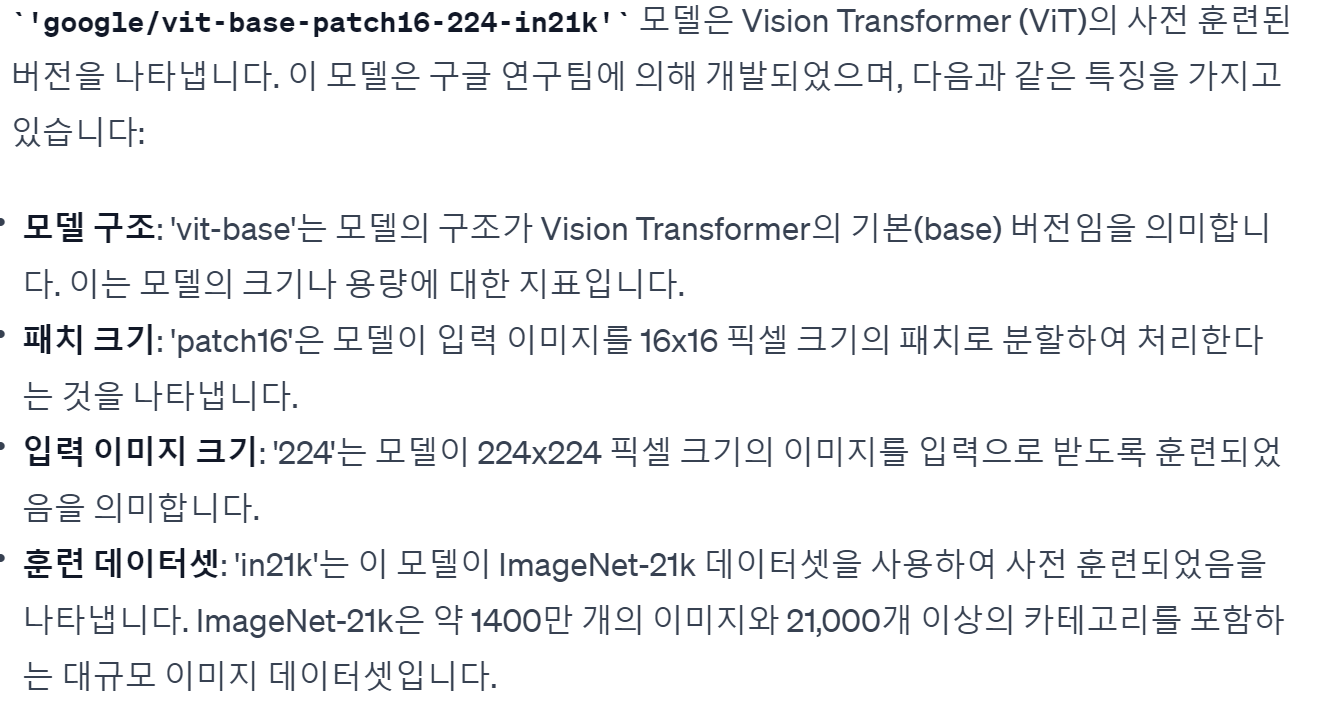

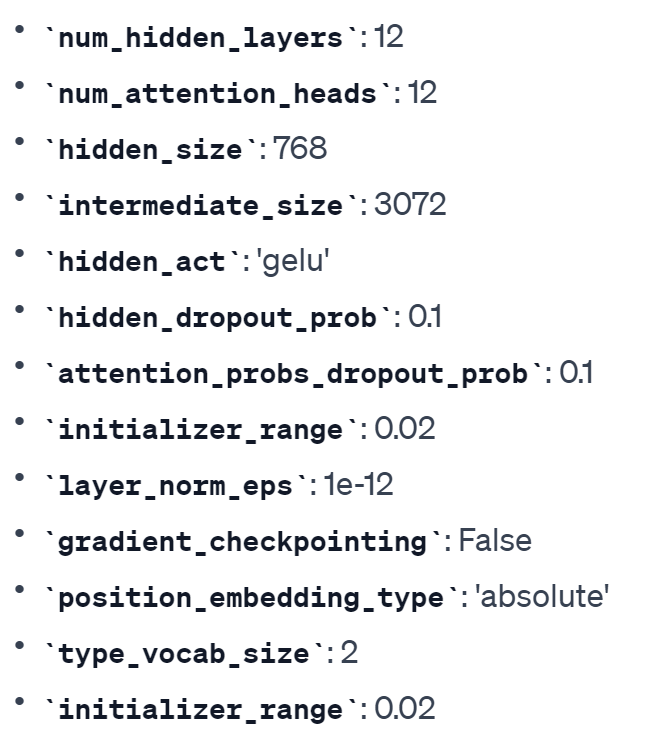

In [ ]:
import torch
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from transformers import ViTForImageClassification, ViTImageProcessor
import concurrent.futures
import random
import os
from PIL import Image

In [ ]:
from torchvision import transforms
from transformers import ViTFeatureExtractor

In [ ]:
##데이터 전처리 및 데이터셋
from torchvision import datasets, transforms
from transformers import ViTImageProcessor
import psutil
import random

# ViT 특성 추출기
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k',do_rescale=False)

# 데이터셋을 로드하고 전처리를 진행합니다.
transform = transforms.Compose([
    transforms.Lambda(lambda image: image.convert('RGB')),
    transforms.Resize((224, 224)), # ViT에 맞는 이미지 크기
    transforms.ToTensor(),
])

data_dir = '/content/drive/MyDrive/TAVE/newactor'
# 데이터셋 로드
original_dataset = datasets.ImageFolder(data_dir, transform=transform)

In [ ]:
# 각 클래스당 이미지를 60개로 제한하여 랜덤 샘플링
max_images_per_class = 60
filtered_dataset = []

for class_dir in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_dir)
    if os.path.isdir(class_path):
        class_images = [item for item in original_dataset.imgs if os.path.dirname(item[0]) == class_path]
        random.shuffle(class_images)
        selected_images = class_images[:max_images_per_class]
        filtered_dataset.extend(selected_images)

# 이미지 파일 경로와 레이블을 포함하는 리스트 생성
filtered_data = [(item[0], item[1]) for item in filtered_dataset]

# 클래스 정보 가져오기
num_classes = len(original_dataset.classes)

# 사용자 정의 데이터셋 클래스
class CustomDataset(Dataset):
    def __init__(self, data, num_classes, transform=None):
        self.data = data
        self.transform = transform
        self.num_classes = num_classes

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        return image, label

# 사용자 정의 데이터셋을 생성
filtered_dataset = CustomDataset(filtered_data, num_classes, transform=transform)

In [ ]:
def get_gpu_memory():
    if torch.cuda.is_available():
        reserved = torch.cuda.memory_reserved()
        allocated = torch.cuda.memory_allocated()
        available = reserved - allocated
        return allocated / 1e9, available / 1e9  # GB 단위로 반환
    else:
        return None

In [ ]:
import torch
from sklearn.metrics import accuracy_score
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import DataLoader
from transformers import ViTForImageClassification
import concurrent.futures

# 모델 학습을 위한 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 모델 로드 (original_dataset을 기반으로)
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', num_labels=len(original_dataset.classes))
model.to(device)

# # 모델 드롭아웃 비율 설정
# model.config.hidden_dropout_prob = 0.2

model.classifier = torch.nn.Linear(model.config.hidden_size, len(original_dataset.classes)).to(device)

# 모델 일부 레이어 미세 조정을 위한 초기 가중치 설정
for param in model.classifier.parameters():
    param.requires_grad = True  # 해당 레이어를 미세 조정 가능하도록 설정

# 학습을 위한 설정
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
criterion = torch.nn.CrossEntropyLoss()
scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: 0.95 ** epoch)  # 에포크마다 학습률을 0.95배로 줄임

loader = DataLoader(filtered_dataset, batch_size=32, shuffle=True, num_workers=4)

epoch_accuracies = []
epoch_losses = []

# 데이터 로딩 및 전처리 속도 향상을 위한 함수
def process_data(images, labels, processor, device):
    inputs = processor(images=images, return_tensors="pt")
    inputs = inputs.to(device)
    labels = labels.to(device)
    return inputs, labels

# 학습 루프
model.train()
for epoch in range(50):
    total_loss = 0.0
    total_accuracy = 0.0
    total_batches = 0

    with concurrent.futures.ThreadPoolExecutor() as executor:
        for images, labels in loader:
            inputs, labels = executor.submit(process_data, images, labels, processor, device).result()

            # 모델에 데이터 입력
            outputs = model(**inputs)
            logits = outputs.logits

            # 손실 계산
            loss = criterion(logits, labels)

            # 역전파 및 가중치 업데이트
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # 손실 및 정확도 누적
            total_loss += loss.item()
            predicted_labels = torch.argmax(logits, dim=1)
            accuracy = accuracy_score(labels.cpu(), predicted_labels.cpu())
            total_accuracy += accuracy
            total_batches += 1

    # 에포크 종료 후 손실과 정확도 계산
    avg_loss = total_loss / total_batches
    avg_accuracy = total_accuracy / total_batches
    print(f"Epoch {epoch + 1}/{10}: Loss: {avg_loss:.4f}, Accuracy: {avg_accuracy:.4f}")

    # 에포크별 정확도와 손실 저장
    epoch_accuracies.append(avg_accuracy)
    epoch_losses.append(avg_loss)

    # 학습 스케줄러 업데이트
    scheduler.step()

    # GPU 메모리 사용량 출력
    gpu_memory = psutil.virtual_memory().total
    print(f"GPU Memory - Allocated: {gpu_memory:.2f} GB")

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10: Loss: 5.3798, Accuracy: 0.0219
GPU Memory - Allocated: 89632866304.00 GB
Epoch 2/10: Loss: 5.0526, Accuracy: 0.1309
GPU Memory - Allocated: 89632866304.00 GB
Epoch 3/10: Loss: 4.7254, Accuracy: 0.3472
GPU Memory - Allocated: 89632866304.00 GB
Epoch 4/10: Loss: 4.3893, Accuracy: 0.5857
GPU Memory - Allocated: 89632866304.00 GB
Epoch 5/10: Loss: 4.0329, Accuracy: 0.7687
GPU Memory - Allocated: 89632866304.00 GB
Epoch 6/10: Loss: 3.6396, Accuracy: 0.8855
GPU Memory - Allocated: 89632866304.00 GB
Epoch 7/10: Loss: 3.2251, Accuracy: 0.9515
GPU Memory - Allocated: 89632866304.00 GB
Epoch 8/10: Loss: 2.8012, Accuracy: 0.9801
GPU Memory - Allocated: 89632866304.00 GB
Epoch 9/10: Loss: 2.3835, Accuracy: 0.9913
GPU Memory - Allocated: 89632866304.00 GB
Epoch 10/10: Loss: 1.9846, Accuracy: 0.9964
GPU Memory - Allocated: 89632866304.00 GB
Epoch 11/10: Loss: 1.6234, Accuracy: 0.9979
GPU Memory - Allocated: 89632866304.00 GB
Epoch 12/10: Loss: 1.3124, Accuracy: 0.9985
GPU Memory - Alloca

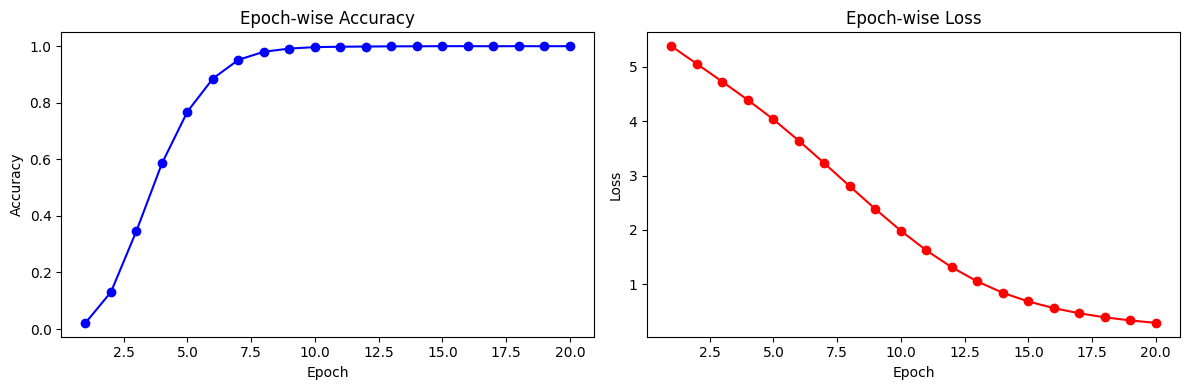

In [ ]:
# 정확도와 손실 그래프 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, 21), epoch_accuracies[:20], marker='o', linestyle='-',color='blue')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Epoch-wise Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(1, 21), epoch_losses[:20], marker='o', linestyle='-',color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch-wise Loss')

plt.tight_layout()
plt.show()

In [ ]:
# 이미지 전처리 함수 정의
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# 입력 이미지 로드 및 전처리
image_path = '/content/drive/MyDrive/TAVE/character/웹툰_최종/소녀의세계/권승하.png'  # 새로운 입력 이미지 파일 경로 설정
image = Image.open(image_path)
if image.mode == 'RGBA':  # 만약 4채널 이미지라면
    image = image.convert('RGB')  # 알파 채널을 제거하여 3채널로 변환
input_image = preprocess(image).unsqueeze(0)  # 모델은 배치 크기 1을 예상하므로 unsqueeze(0)을 사용하여 차원 추가

# 모델로 입력 이미지 예측
with torch.no_grad():
    outputs = model(input_image.to(device))
    logits = outputs.logits

# 상위 3개 클래스 예측
top_k = 3
probabilities, class_indices = torch.topk(logits, top_k, dim=1)
class_probabilities = torch.nn.functional.softmax(probabilities, dim=1)[0] * 100.0

# 예측 결과 출력
for i in range(top_k):
    class_idx = class_indices[0, i].item()
    class_probability = class_probabilities[i].item()
    class_name = original_dataset.classes[class_idx]
    print(f"Class: {class_name}, Probability: {class_probability:.2f}%")

# 최고 확률 클래스와 확률 출력
best_class_idx = class_indices[0, 0].item()
best_class_probability = class_probabilities[0].item()
best_class_name = original_dataset.classes[best_class_idx]
print(f"Best Class: {best_class_name}, Probability: {best_class_probability:.2f}%")

Class: 김선호_수정본, Probability: 35.96%
Class: 이도현_수정본, Probability: 34.20%
Class: 류승범_수정본, Probability: 29.84%
Best Class: 김선호_수정본, Probability: 35.96%


In [ ]:
import json

# 클래스 레이블 정보를 저장할 JSON 파일 경로
class_labels_path = "/content/drive/MyDrive/TAVE/class_labels.json_utf-16be"

# 클래스 레이블 정보 생성 및 저장 (ensure_ascii=False를 설정하여 한글 표시)
class_labels = {i: class_name for i, class_name in enumerate(original_dataset.classes)}
with open(class_labels_path, "w", encoding="utf-16be") as json_file:
    json.dump(class_labels, json_file, ensure_ascii=False)



---



### 예측

In [ ]:
# 모델 저장 경로 지정
model_save_path = "/content/drive/MyDrive/TAVE/ViT_image_classification_model.pth"

# 모델 저장
torch.save(model.state_dict(), model_save_path)

In [ ]:
import torch
from PIL import Image
from transformers import ViTForImageClassification, ViTFeatureExtractor

# 모델 저장 디렉토리 경로 설정 (이전에 저장한 경로와 일치해야 함)
model_path = "/content/drive/MyDrive/TAVE/ViT_image_classification_model.pth"

# 저장한 모델 상태 사전 불러오기
model_state_dict = torch.load(model_path)

# 모델 정의 (ViTForImageClassification)
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k",num_labels=235)
model.load_state_dict(model_state_dict)

# 새로운 이미지 로드
image_path = "/content/drive/MyDrive/TAVE/character/웹툰_최종/파운더/양진용.png"
image = Image.open(image_path)

# 이미지를 RGB 형식으로 변환
image = image.convert("RGB")

# 이미지 전처리
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")
inputs = feature_extractor(images=image, return_tensors="pt")
input_data = inputs  # 모델을 CPU로 이동한 후 입력 데이터 생성

# 모델을 사용하여 예측 수행
with torch.no_grad():
    outputs = model(**input_data)
    logits = outputs.logits

# 상위 3개 클래스 예측
top_k = 3
probabilities, class_indices = torch.topk(logits, top_k, dim=1)
class_probabilities = torch.nn.functional.softmax(probabilities, dim=1)[0] * 100.0

# 예측 결과 출력
for i in range(top_k):
    class_idx = class_indices[0, i].item()
    class_probability = class_probabilities[i].item()
    class_name = original_dataset.classes[class_idx]
    class_name = class_name.split('_')[0]
    # print(f"Class: {class_name}, Probability: {class_probability:.2f}%")
    print(class_name)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


김성균
봉태규
이병헌


/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
